<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [29]:
def create_directories(output_dir, splits, classes):
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

def list_all_images(source_dir, classes):
    all_images = []
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        all_images.extend([(img, cls) for img in images])
    return all_images

def split_dataset(all_images):
    train_val_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_images, val_images, test_images

def copy_images(images, output_dir, split):
    for img_path, cls in images:
        dest_dir = os.path.join(output_dir, split, cls)
        shutil.copy(img_path, dest_dir)

def prepare_data(source_dir, output_dir, classes):
    splits = ['train', 'validation', 'test']
    create_directories(output_dir, splits, classes)
    all_images = list_all_images(source_dir, classes)
    train_images, val_images, test_images = split_dataset(all_images)
    copy_images(train_images, output_dir, 'train')
    copy_images(val_images, output_dir, 'validation')
    copy_images(test_images, output_dir, 'test')
    return len(train_images), len(val_images), len(test_images)

def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()


In [36]:
source_dir = "/content/drive/MyDrive/Colab Notebooks/thermal images UL"
output_dir = "/content/drive/MyDrive/Colab Notebooks/thermal images UL"
classes = ['healthy', 'Blast', 'BLB', 'hispa', 'leaf folder', 'leaf spot']

In [37]:
# Prepare data
train_count, val_count, test_count = prepare_data(source_dir, output_dir, classes)
print(f"Training set: {train_count} images")
print(f"Validation set: {val_count} images")
print(f"Test set: {test_count} images")


Training set: 381 images
Validation set: 127 images
Test set: 128 images


In [38]:
# Step 1: Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 381 images belonging to 8 classes.
Found 127 images belonging to 8 classes.
Found 128 images belonging to 8 classes.


In [39]:
# Step 2: Build the CNN Model
model = build_model(input_shape=(224, 224, 3), num_classes=train_generator.num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Step 3: Training the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - accuracy: 0.2915 - loss: 3.0076 - val_accuracy: 0.3543 - val_loss: 1.7366
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.3135 - loss: 1.7210 - val_accuracy: 0.3071 - val_loss: 1.6019
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.3655 - loss: 1.6133 - val_accuracy: 0.3937 - val_loss: 1.4952
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.4075 - loss: 1.5472 - val_accuracy: 0.4567 - val_loss: 1.4013
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.4293 - loss: 1.4181 - val_accuracy: 0.4331 - val_loss: 1.3800
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.4389 - loss: 1.4516 - val_accuracy: 0.4567 - val_loss: 1.3647
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.4611 - loss: 1.3576 - val_accuracy: 0.5512 - val_loss: 1.2591
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.4985 - loss: 1.3789 - val_accuracy: 0.5354 - val_loss:

In [41]:
# Step 4: Evaluate the Model
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

# Test Accuracy
if test_generator:
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.5065616965293884
Validation Accuracy: 0.5669291615486145
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5010 - loss: 1.1924
Testing Accuracy: 0.5078125


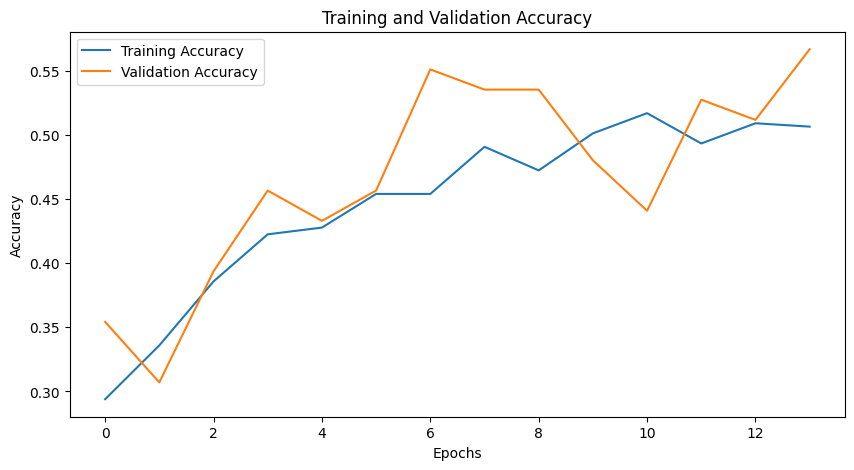

In [42]:
# Step 5: Plot Training/Validation Accuracy and Loss
plot_history(history)